In [1]:
## Upload datasets ## 
from google.colab import files
uploaded = files.upload() 

Saving train.csv to train.csv
Saving test.csv to test.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [180]:
## Install regressors library
#!pip install regressors

In [161]:
## Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from xgboost import XGBRegressor
from regressors import stats,plots
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,mean_absolute_error
from scipy.stats import pearsonr
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.api as smt 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import explained_variance_score

In [ ]:
## Options and settings ##
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999 

In [5]:
## Import training/test datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

## All data
all_data = [train_df,test_df]

In [ ]:
## display training data
train_df.head()

Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0   1          60       RL  ...        WD         Normal    208500
1   2          20       RL  ...        WD         Normal    181500
2   3          60       RL  ...        WD         Normal    223500
3   4          70       RL  ...        WD        Abnorml    140000
4   5          60       RL  ...        WD         Normal    250000

[5 rows x 81 columns]

In [ ]:
## Descriptive statistics for numerical data
train_df.describe()

Id   MSSubClass  ...       YrSold      SalePrice
count  1460.000000  1460.000000  ...  1460.000000    1460.000000
mean    730.500000    56.897260  ...  2007.815753  180921.195890
std     421.610009    42.300571  ...     1.328095   79442.502883
min       1.000000    20.000000  ...  2006.000000   34900.000000
25%     365.750000    20.000000  ...  2007.000000  129975.000000
50%     730.500000    50.000000  ...  2008.000000  163000.000000
75%    1095.250000    70.000000  ...  2009.000000  214000.000000
max    1460.000000   190.000000  ...  2010.000000  755000.000000

[8 rows x 38 columns]

In [ ]:
## Descriptive statistics for categorical data
train_df.describe(include = "O")

MSZoning Street Alley LotShape  ...  Fence MiscFeature SaleType SaleCondition
count      1460   1460    91     1460  ...    281          54     1460          1460
unique        5      2     2        4  ...      4           4        9             6
top          RL   Pave  Grvl      Reg  ...  MnPrv        Shed       WD        Normal
freq       1151   1454    50      925  ...    157          49     1267          1198

[4 rows x 43 columns]

In [6]:
## Check missing values

print(train_df.isnull().sum())
print("\n")
print("-"*40)
print("\n")
print(test_df.isnull().sum())

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


----------------------------------------


Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64


In [8]:
## Cleaning data ##
## For this features, NA means there is no Basement, no Pool, No garage etc .. 
## Based on the data description I decided to replace NA values for those features with the correct meaning ##
for dataset in all_data:
  dataset["Alley"] = dataset["Alley"].replace(np.nan,"No_Alley_Access")
  dataset["BsmtQual"] = dataset["BsmtQual"].replace(np.nan,"No_basement")
  dataset["BsmtCond"] = dataset["BsmtCond"].replace(np.nan,"No_basement")
  dataset["BsmtExposure"] = dataset["BsmtExposure"].replace(np.nan,"No_basement")
  dataset["BsmtFinType1"] = dataset["BsmtFinType1"].replace(np.nan,"No_basement")
  dataset["BsmtFinType2"] = dataset["BsmtFinType2"].replace(np.nan,"No_basement")
  dataset["FireplaceQu"] = dataset["FireplaceQu"].replace(np.nan,"No_Fireplace")
  dataset["GarageType"] = dataset["GarageType"].replace(np.nan,"No_Garage")
  dataset["GarageFinish"] = dataset["GarageFinish"].replace(np.nan,"No_Garage")
  dataset["GarageQual"] = dataset["GarageQual"].replace(np.nan,"No_Garage")
  dataset["GarageCond"] = dataset["GarageCond"].replace(np.nan,"No_Garage")
  dataset["PoolQC"] = dataset["PoolQC"].replace(np.nan,"No_Pool")
  dataset["Fence"] = dataset["Fence"].replace(np.nan,"No_Fence")
  dataset["MiscFeature"] = dataset["MiscFeature"].replace(np.nan,"None")

In [9]:
## Encoding Categorical Values using LabelEncoder() ## 
## I encoded categorical data before handling missing values ##

train_data = train_df.copy()
test_data = test_df.copy()

label_encoder = LabelEncoder()
categ_cols = list(train_df.select_dtypes(include = ["object"]).columns)

for dataset in [train_data,test_data]:
  dataset[categ_cols] = dataset[categ_cols].apply(lambda serie : pd.Series(label_encoder.fit_transform(serie[serie.notnull()]), index = serie[serie.notnull()].index))

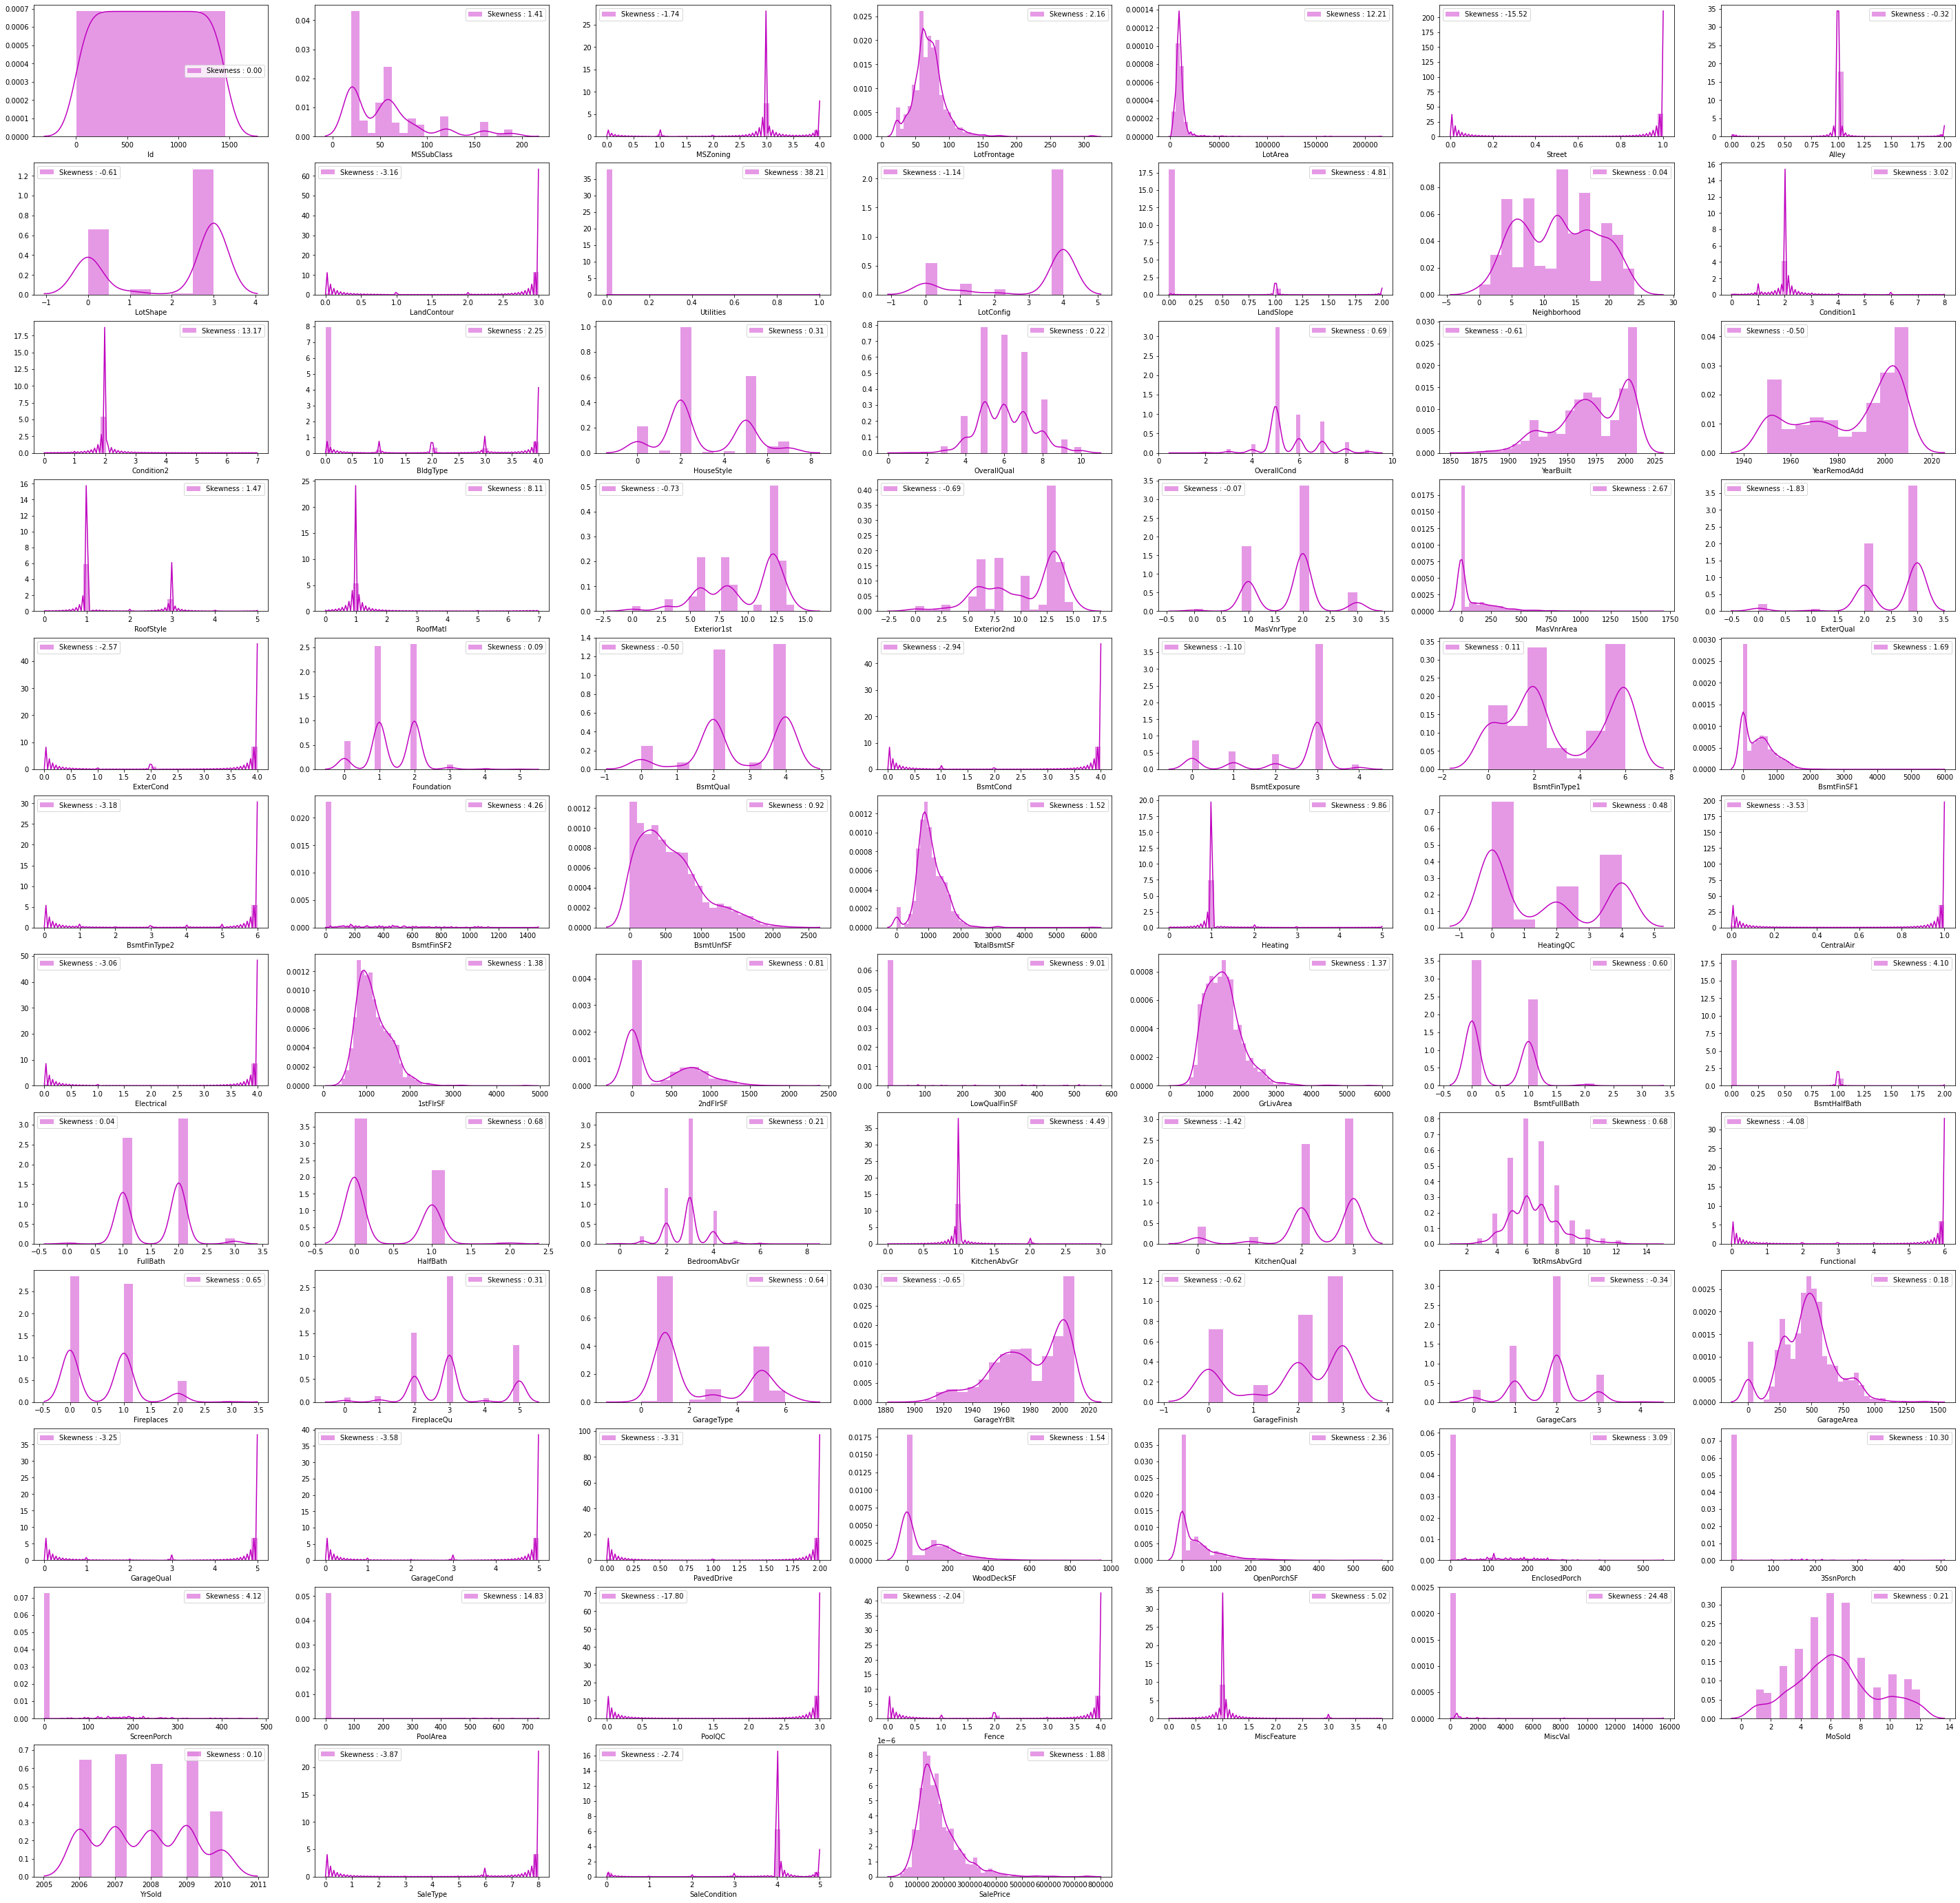

In [12]:
## plot distribution of all variable ##

i = 1
cols_train = list(train_data.columns)
plt.figure(figsize = (50,50))
for col in cols_train:
  plt.subplot(12,7,i)
  sns.distplot(a = train_data[col], color ="m" , label = "Skewness : %.2f"%(train_data[col].skew()))
  plt.xlabel(col)
  i += 1
  plt.legend()
plt.show()  

In [13]:
## Applying transformation log to all variables to reduce skewness
for dataset in [train_data,test_data]:
  for col in list(test_data.columns):
    dataset[col] = dataset[col].apply(lambda x : np.log1p(x))

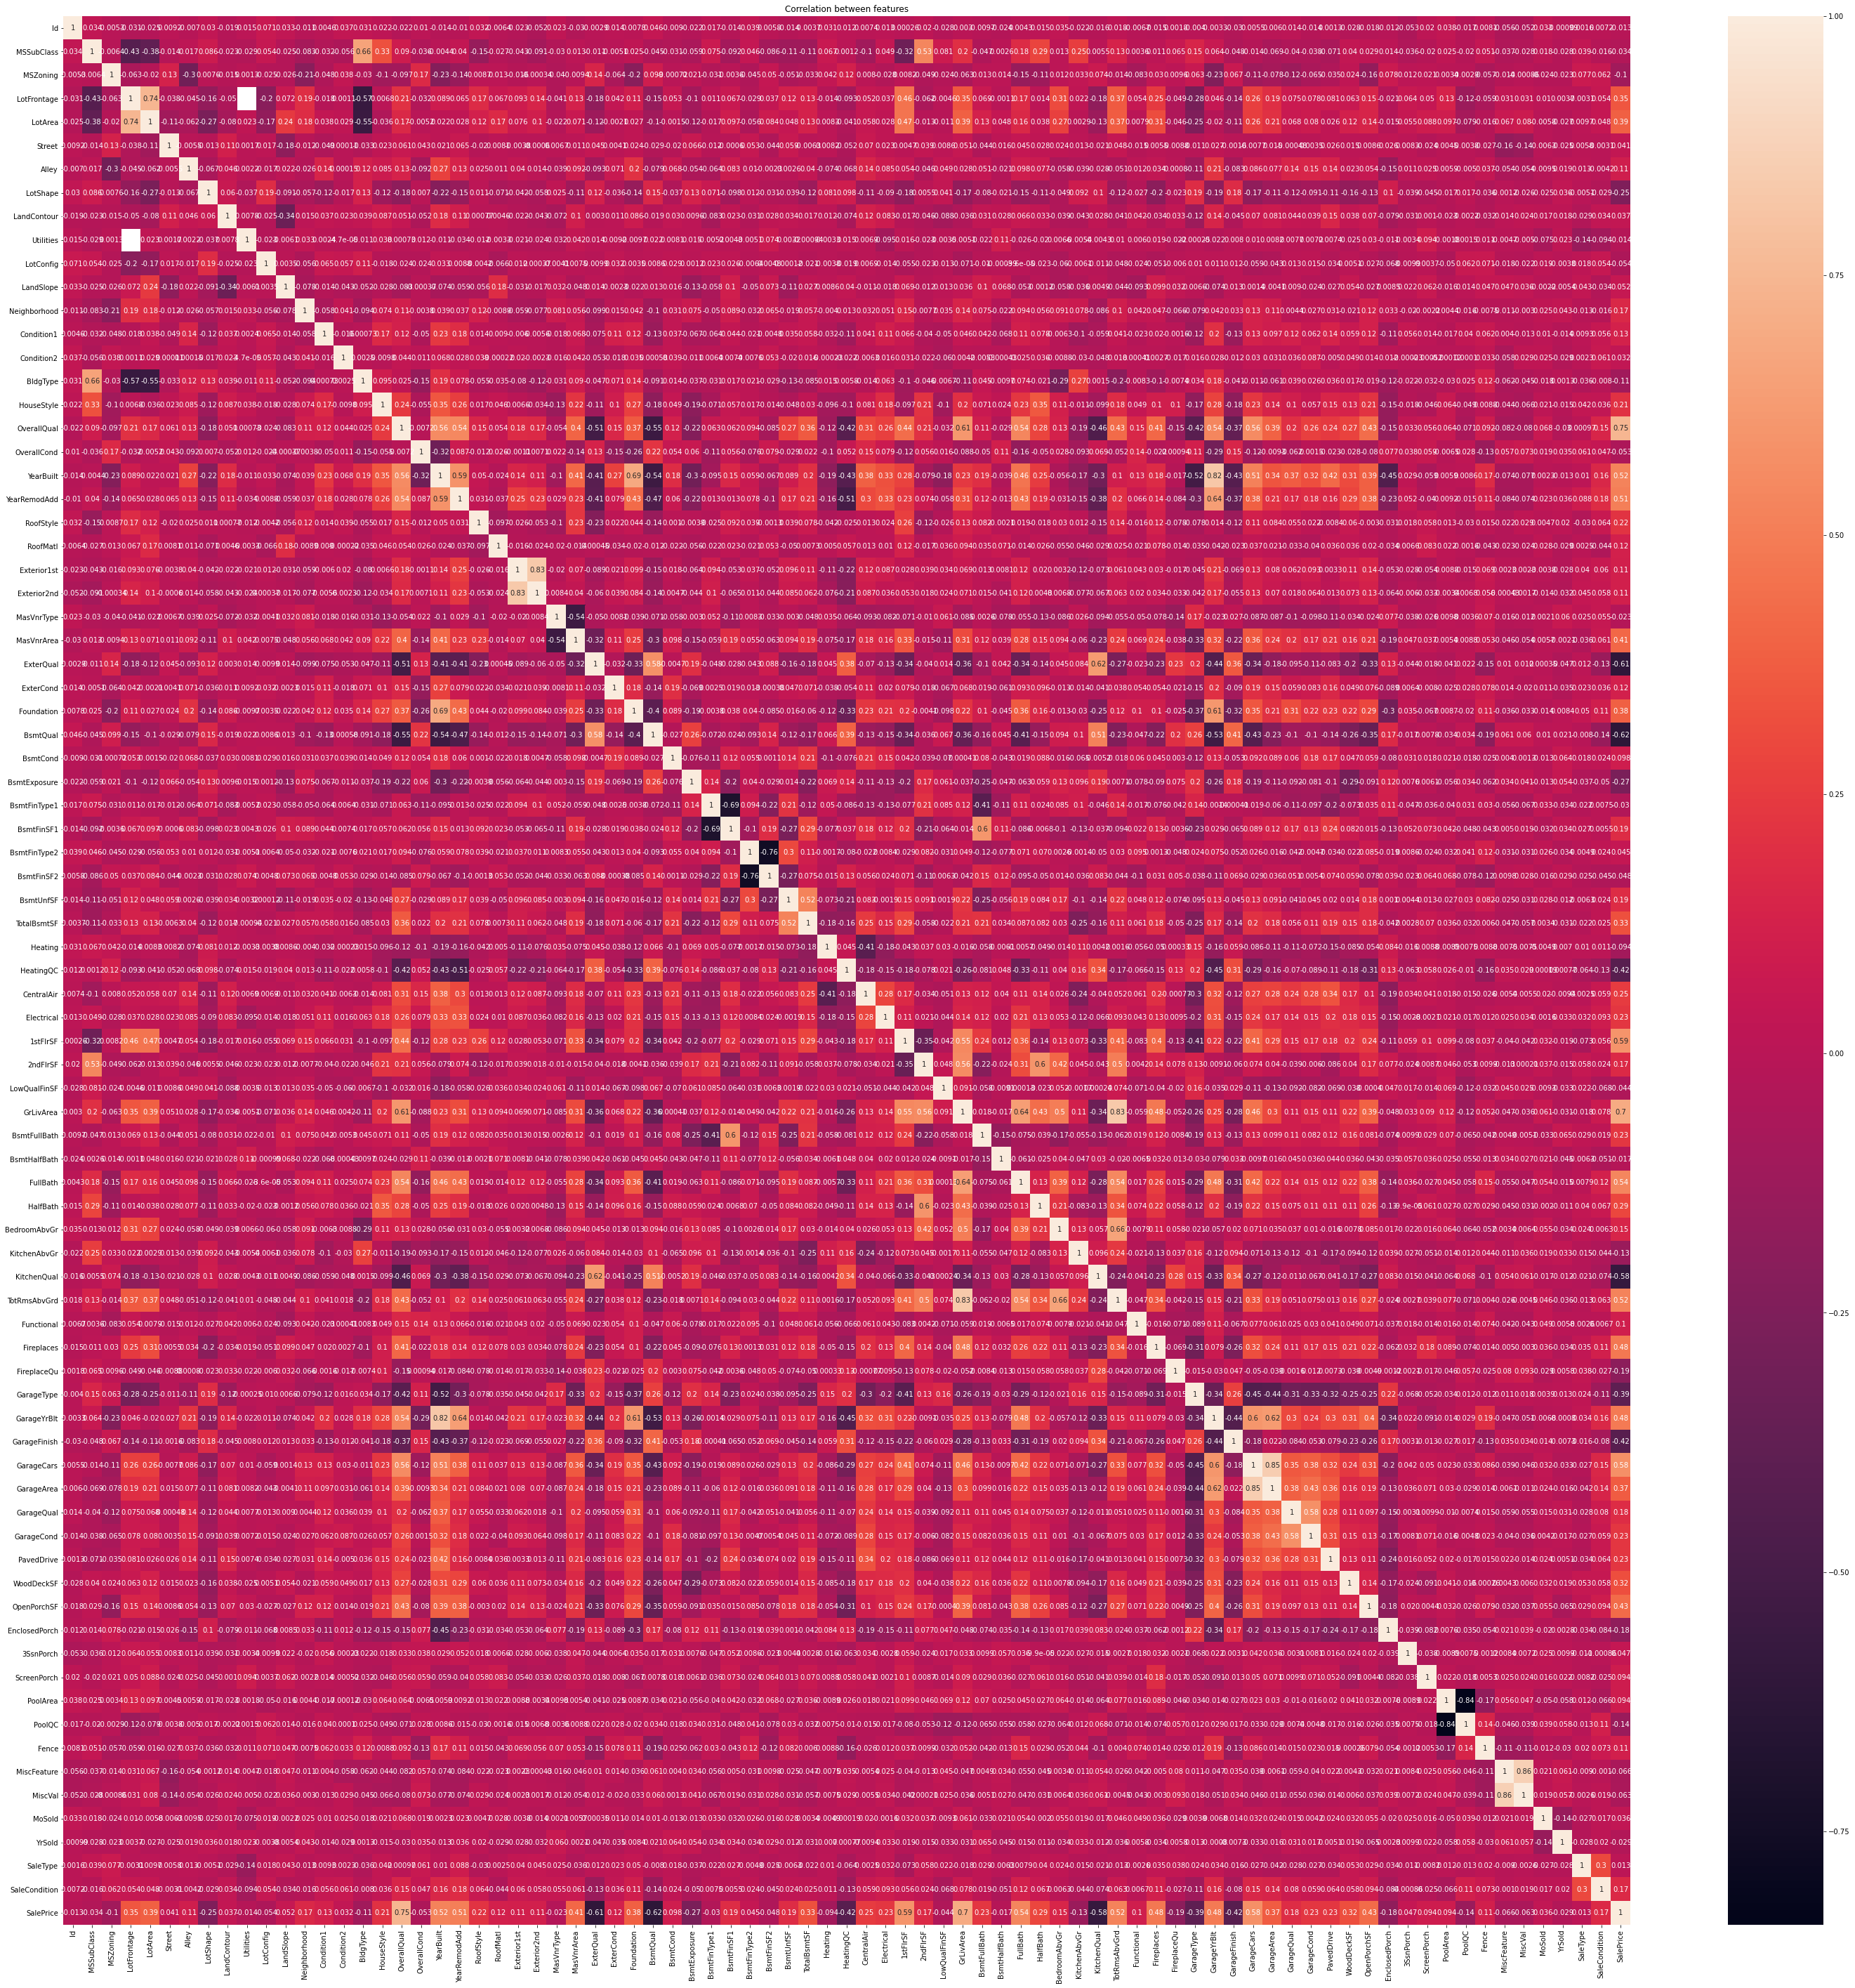

In [14]:
## Heatmap to show correlations between variable using pearson method ##
train_corr = train_data.corr(method = "pearson")

plt.figure(figsize = (50,50))
plt.title("Correlation between features")
sns.heatmap(data = train_corr,annot = True)

**IMPUTE MISSING VALUES**

In [16]:
## Imputing missing values for : Categorical & Numerical data ##

from sklearn.impute import SimpleImputer
## Numerical data
imp = SimpleImputer(missing_values = np.nan , strategy = "median")

## Training data
train_data["MasVnrArea"] = imp.fit_transform(np.asarray(train_data["MasVnrArea"]).reshape(-1,1))
train_data["LotFrontage"] = imp.fit_transform(np.asarray(train_data["LotFrontage"]).reshape(-1,1))
train_data["GarageYrBlt"] = imp.fit_transform(np.asarray(train_data["GarageYrBlt"]).reshape(-1,1))

## Test data
test_data["GarageYrBlt"] = imp.fit_transform(np.asarray(test_data["GarageYrBlt"]).reshape(-1,1))
test_data["LotFrontage"] = imp.fit_transform(np.asarray(test_data["LotFrontage"]).reshape(-1,1))
test_data["MasVnrArea"] = imp.fit_transform(np.asarray(test_data["MasVnrArea"]).reshape(-1,1))
test_data["BsmtFinSF1"] = imp.fit_transform(np.asarray(test_data["BsmtFinSF1"]).reshape(-1,1))
test_data["BsmtFinSF2"] = imp.fit_transform(np.asarray(test_data["BsmtFinSF2"]).reshape(-1,1))
test_data["TotalBsmtSF"] = imp.fit_transform(np.asarray(test_data["TotalBsmtSF"]).reshape(-1,1))
test_data["GarageArea"] = imp.fit_transform(np.asarray(test_data["GarageArea"]).reshape(-1,1))
test_data["BsmtUnfSF"] = imp.fit_transform(np.asarray(test_data["BsmtUnfSF"]).reshape(-1,1))


## Categorical data
imp_categ = SimpleImputer(missing_values = np.nan , strategy = "most_frequent")

## Training data
train_data["GarageFinish"] = imp_categ.fit_transform(np.asarray(train_data["GarageFinish"]).reshape(-1,1))
train_data["BsmtQual"] = imp_categ.fit_transform(np.asarray(train_data["BsmtQual"]).reshape(-1,1))
train_data["BsmtExposure"] = imp_categ.fit_transform(np.asarray(train_data["BsmtExposure"]).reshape(-1,1))
train_data["MasVnrType"] = imp_categ.fit_transform(np.asarray(train_data["MasVnrType"]).reshape(-1,1))
train_data["Electrical"] = imp_categ.fit_transform(np.asarray(train_data["Electrical"]).reshape(-1,1))



## Test data
test_data["BsmtFullBath"] = imp_categ.fit_transform(np.asarray(test_data["BsmtFullBath"]).reshape(-1,1))
test_data["BsmtHalfBath"] = imp_categ.fit_transform(np.asarray(test_data["BsmtHalfBath"]).reshape(-1,1))
test_data["Utilities"] = imp_categ.fit_transform(np.asarray(test_data["Utilities"]).reshape(-1,1))
test_data["Exterior1st"] = imp_categ.fit_transform(np.asarray(test_data["Exterior1st"]).reshape(-1,1))
test_data["Exterior2nd"] = imp_categ.fit_transform(np.asarray(test_data["Exterior2nd"]).reshape(-1,1))
test_data["MasVnrType"] = imp_categ.fit_transform(np.asarray(test_data["MasVnrType"]).reshape(-1,1))
test_data["MSZoning"] = imp_categ.fit_transform(np.asarray(test_data["MSZoning"]).reshape(-1,1))
test_data["GarageCars"] = imp_categ.fit_transform(np.asarray(test_data["GarageCars"]).reshape(-1,1))
test_data["KitchenQual"] = imp_categ.fit_transform(np.asarray(test_data["KitchenQual"]).reshape(-1,1))
test_data["Functional"] = imp_categ.fit_transform(np.asarray(test_data["Functional"]).reshape(-1,1))
test_data["GarageCars"] = imp_categ.fit_transform(np.asarray(test_data["GarageCars"]).reshape(-1,1))
test_data["SaleType"] = imp_categ.fit_transform(np.asarray(test_data["SaleType"]).reshape(-1,1))

In [17]:
## check missing values
print("Train data missing values : \n" , train_data.isnull().sum())
print("\n")
print("-"*40)
print("\n")
print("Test data missing values : \n" , test_data.isnull().sum()) 

Train data missing values : 
 Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 81, dtype: int64


----------------------------------------


Test data missing values : 
 Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 80, dtype: int64


In [18]:
## Implementation of stepwise regression ##
## Source : https://github.com/AakkashVijayakumar/stepwise-regression/blob/master/stepwise_regression/step_reg.py  

## I used stepwise regression to keep just important independent variables ##

## After I adjusted the final features to our model in order to obtain a correct bias and variance ##

def stepwise_regression(X, y,
                       threshold_in,
                       verbose=False):
    """
    Parameters : X -- Independent variable for training data
                 y -- Target variable 
                 threshold_in : significance level to reject null-hypothesis

    Return : List of features to keep

    """
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded,dtype = "float64")
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break
    
    return included

## Predictor variables without Id
independent_var = set(list(train_data.columns)).difference(set(["Id","SalePrice"]))

## Stepwise regression with a significance level : alpha = 0.05
print(stepwise_regression(train_data[list(independent_var)],train_data["SalePrice"],threshold_in = 0.05)) 


['OverallQual', 'GrLivArea', 'ExterQual', 'LotArea', 'BsmtQual', 'BsmtFinSF1', 'KitchenQual', 'YearBuilt', 'OverallCond', '1stFlrSF', 'KitchenAbvGr', 'Functional', 'GarageCars', 'GarageArea', 'PoolQC', 'PoolArea', 'RoofMatl', 'SaleCondition', 'Fireplaces', 'BsmtExposure', 'MSSubClass', 'BedroomAbvGr', 'GarageType', 'LowQualFinSF', 'TotRmsAbvGrd', 'BsmtFullBath', 'Exterior1st', 'Street', 'FireplaceQu', 'RoofStyle', 'LotFrontage', 'BsmtCond']


**PREPARING FEATURES TO TRAIN OUR MODELS**

In [19]:
X = train_data[['OverallQual', 'GrLivArea', 'BsmtFinSF1', 'ExterQual', 'LotArea', 'GarageCars', 'KitchenQual', 'MasVnrArea', 'BsmtQual', 'OverallCond',
                'YearBuilt', 'MSSubClass', 'BsmtExposure', 'Fireplaces', 'MasVnrType', 'RoofMatl', 'Functional', 'PoolQC', 'PoolArea', 'WoodDeckSF',
                'SaleCondition', 'Exterior1st', 'BsmtFullBath', 'TotRmsAbvGrd', 'BedroomAbvGr', 'KitchenAbvGr', 
                '1stFlrSF', '2ndFlrSF', 'LotFrontage', 'Condition2', 'GarageType', 'Street', 'ScreenPorch', 'GarageFinish', 'FireplaceQu', 'Neighborhood']]
y = train_data["SalePrice"]

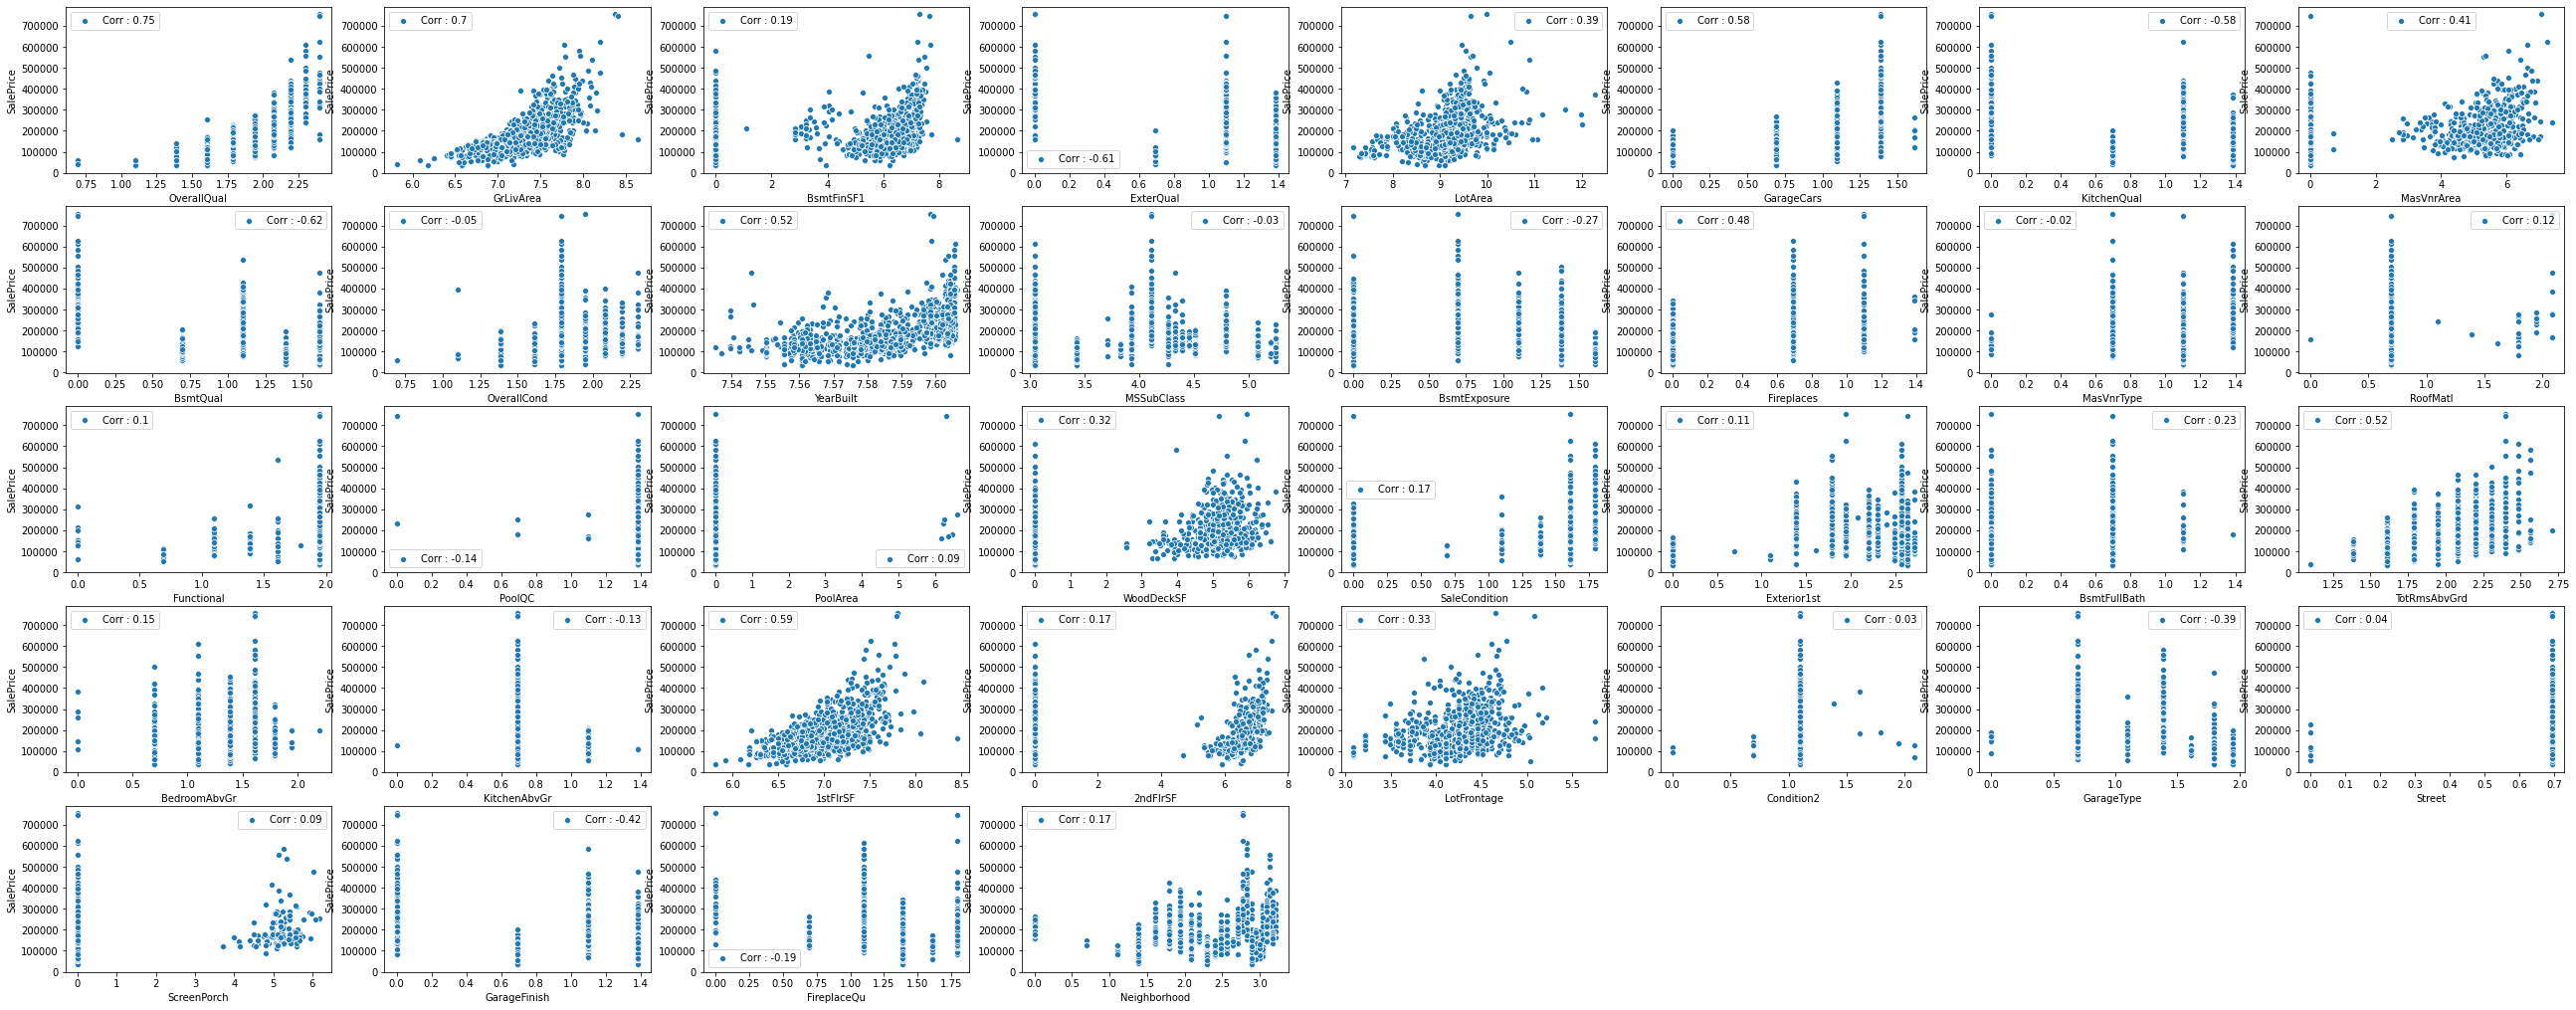

In [43]:
## Plot the variable used to train the model 
## Check if there is a linear relation between predictors and target variables
## Using Scatter plot

i = 1
cols_train = list(X.columns)
plt.figure(figsize = (45,40))
for col in cols_train:
  plt.subplot(11,8,i)
  sns.scatterplot(x = X[col] , y = y , data = X , label = "Corr : {}".format(round(pearsonr(X[col],train_data["SalePrice"])[0],2))) 
  plt.xlabel(col)
  i += 1
  #plt.legend()
plt.show()

In [44]:
## Z-score method to normalize our dataset
## Normalize data to reduce multicolinearity between features and
## to have a better accuracy 

## Z-score function from scikit-learn
scaler = StandardScaler()

## transform the predictors using StandardScaler()
X_norm = scaler.fit_transform(X)

## Transform the target variable using log to reduce skewness
y_log = np.log1p(y)

In [75]:
## Split the data into Training/Validation dataset 
X_train,X_val,y_train,y_val = train_test_split(X_norm,y_log,test_size = 0.15, random_state = 0)

**TRAINING MODELS**


In [82]:
## Multiple Linear Regression

ols = LinearRegression()
ols.fit(X_train,y_train)
stats.summary(ols,X_train,y_train,xlabels= list(X.columns))

Residuals:
    Min      1Q  Median      3Q     Max
-0.5365 -0.0706 -0.0046  0.0623  1.2003


Coefficients:
                Estimate  Std. Error    t value   p value
_intercept     12.022040    0.003737  3217.2799  0.000000
OverallQual     0.082238    0.006242    13.1753  0.000000
GrLivArea       0.167483    0.014454    11.5872  0.000000
BsmtFinSF1      0.031972    0.004657     6.8654  0.000000
ExterQual      -0.014708    0.005109    -2.8789  0.004059
LotArea         0.045696    0.005320     8.5901  0.000000
GarageCars      0.038367    0.005136     7.4698  0.000000
KitchenQual    -0.024115    0.004915    -4.9066  0.000001
MasVnrArea      0.003236    0.005046     0.6413  0.521467
BsmtQual       -0.021761    0.005376    -4.0474  0.000055
OverallCond     0.054758    0.004076    13.4334  0.000000
YearBuilt       0.089587    0.005956    15.0404  0.000000
MSSubClass     -0.008201    0.005378    -1.5250  0.127520
BsmtExposure   -0.005523    0.004277    -1.2914  0.196800
Fireplaces      0.01729

In [83]:
## R-score using validation dataset ##
print("R-square prediction :", ols.score(X_val,y_val))

R-square prediction : 0.8798747851240882


In [84]:
## Compute the error using Mean Absolute Error as a metric
y_val_pred = ols.predict(X_val)
print("Mean Absolute error :" , mean_absolute_error(y_val,y_val_pred))

Mean Absolute error : 0.0900536694985864


In [87]:
## Assumption OLS :  Autocorrelation
## Using durbin-watson statistic test to assess Autocorrelation i.e Serial Correlation ##

residuals = stats.residuals(ols,X_train,y_train)
durbin_watson(residuals)

## Conclusion : results ~ 2.09 Which means there is no autocorrelation in our model

2.086678095330749

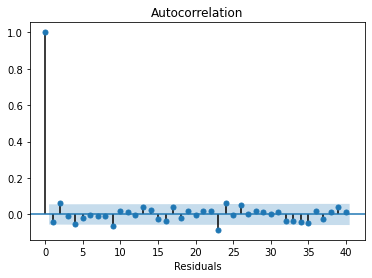

In [93]:
acf = smt.graphics.plot_acf(residuals, lags=40 , alpha=0.05)
plt.xlabel("Residuals")
acf.show()

Text(0, 0.5, 'SalePrice')

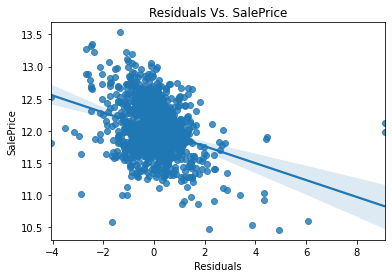

In [88]:
## Another way to check Linearity Assumption of the model 
## Plot observed vs predicted values or resids vs predicted values

sns.regplot(x = residuals , y = y_train)
plt.title("Residuals Vs. SalePrice")
plt.xlabel("Residuals")
plt.ylabel("SalePrice")

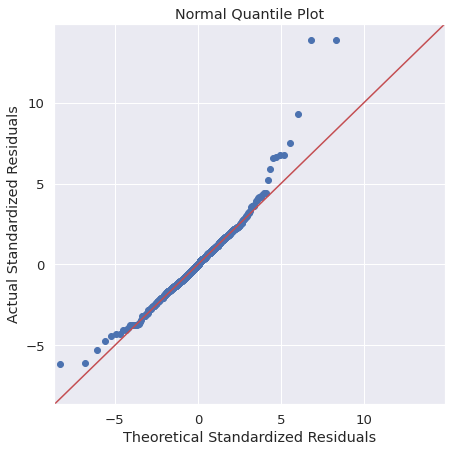

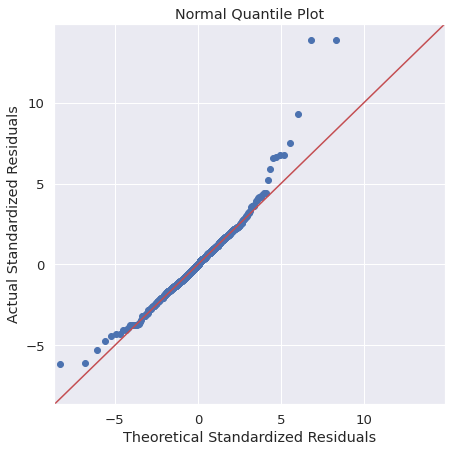

In [94]:
## OLS Assumption : Normality of residuals
## The perfect way to check normality is using normal quantile plots (aka Q-Q plots)
plots.plot_qq(ols, X_train , y_train)

## Conclusion : The data points track the straight line but with some specific values of residuals its not the case
##              => We can not conclude for 100% that residuals follow normal distribution even if it seems the case in the histrogram below.  

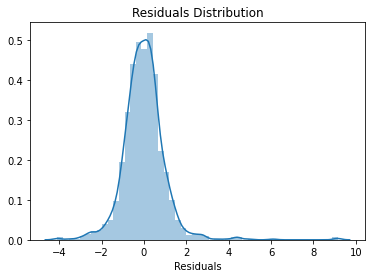

In [99]:
## Distribution of residuals
plt.title("Residuals Distribution")
sns.distplot(a = residuals)
plt.xlabel("Residuals")
plt.show()

In [89]:
## OLS assumption : Mean of Residuals should be approximately zero
residuals.mean()

-3.782452012985626e-16

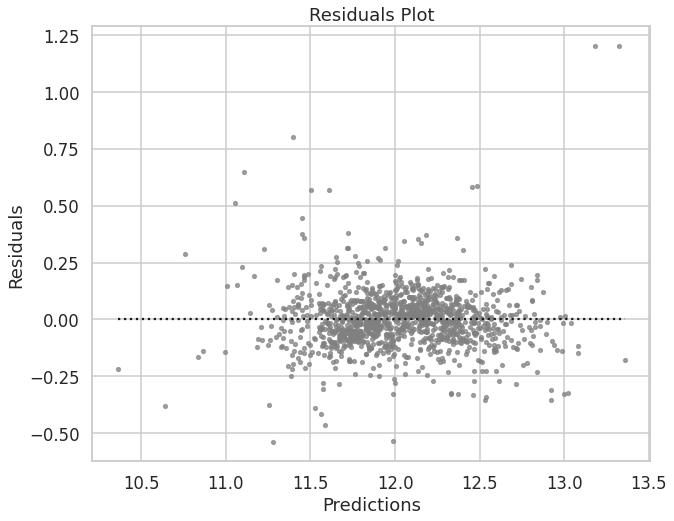

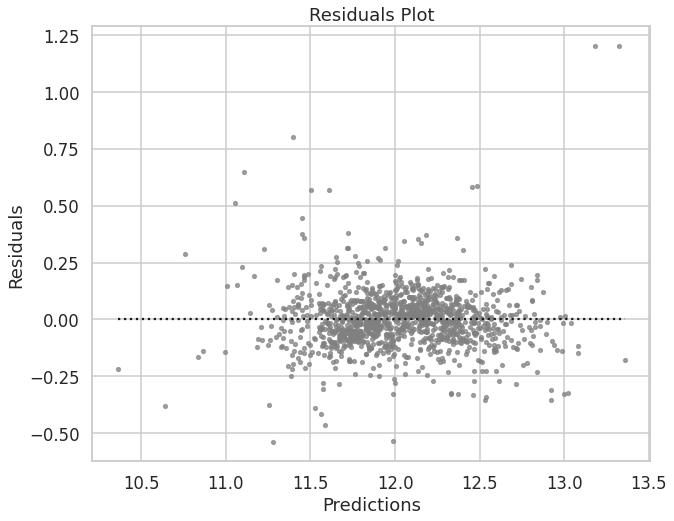

In [100]:
## OLS assumption : Homoscedasticity  ##
## The variance of the error should be consistent for all observations ## 

plots.plot_residuals(ols, X_train , y_train, r_type="raw" )

## Conclusion : In the graph below, we see that the variance is "approximately" the same for all residuals ##
##              => Our model do not suffer a lot from heteroscedasticity 

**OTHER REGRESSION MODELS : XGBOOST, MLPRegressor, RANDOMFOREST** 

In [142]:
xgb_Param_Grid = {"min_child_leaf" : [1,2,3],
                  "max_depth" : [3,6],
                  "subsample" : [0.5,1],
                  "reg_alpha" : [1.5,2,2.5,3],
                  "learning_rate" : [0.001,0.1],
                  "n_jobs" : [8],
                  "silent" : [True]}
XGB = XGBRegressor()
Grid_XGB = GridSearchCV(XGB,xgb_Param_Grid)
Grid_XGB.fit(X_norm,y_log)
XGB_best = Grid_XGB.best_estimator_
XGB_best

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_leaf=1, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=8, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=1.5, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=True, subsample=1, verbosity=1)

In [148]:
RandForest_param_grid = {"min_samples_split" : [2,3,4,5],
                         "max_leaf_nodes" : [2,3,4,5,6],
                         "bootstrap" : [True],
                         "max_samples" : [0.15,0.2]}

RF_reg = RandomForestRegressor()
RandForest_gridCV = GridSearchCV(RF_reg,RandForest_param_grid)
RandForest_gridCV.fit(X_norm,y_log)
RandForest_best = RandForest_gridCV.best_estimator_
RandForest_best

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=6,
                      max_samples=0.15, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [153]:
GBM_param_grid = {"min_samples_split" : [2,3,4],
                  "max_depth" : [3,6],
                  "subsample" : [0.5,1],
                  "learning_rate" : [0.001,0.01,0.1]
                  }

GBM = GradientBoostingRegressor()
GBM_gridCV = GridSearchCV(GBM,GBM_param_grid)
GBM_gridCV.fit(X_norm,y_log)
GBM_best = GBM_gridCV.best_estimator_
GBM_best

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

**LEARNING CURVE TO VISUALIZE THE EFFECT OF OVERFITTING IN THE TRAINING SET**

In [166]:

### Function to plot learning curves
### Adapted from scikit-learn documentation : https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html ####

def plot_learning_curves(estimator,title,X,y,axes = None,ylim = None,cv = None,n_jobs = None,train_sizes = np.linspace(.1,1.0,5)):
  if axes is None:
    _,axes = plt.subplots(1,2,figsize = (20,8))

  if ylim is not None:
    axes[0].set_ylim(*ylim)

  axes[0].set_title(title)
  axes[0].set_xlabel("Training Examples")
  axes[0].set_ylabel("Score")

  ## Learning curves corresponding to the training/validation accuracy 
  train_sizes,train_scores,test_scores,fit_times,_ = learning_curve(estimator,X,y,cv = cv,n_jobs=n_jobs,
                                                                    train_sizes = train_sizes,return_times = True)
  train_scores_mean  = np.mean(train_scores,axis = 1)
  train_scores_std = np.std(train_scores,axis = 1)
  test_scores_mean = np.mean(test_scores,axis = 1)
  test_scores_std = np.std(test_scores,axis = 1)

  ## Learning curves corresponding to the training/validation error

  train_sizes,train_error,test_error,fit_times,_  = learning_curve(estimator,X,y,cv = cv ,
                                                    n_jobs = n_jobs,train_sizes = train_sizes,
                                                    return_times = True , scoring = "neg_root_mean_squared_error")

  train_error_mean = -np.mean(train_error, axis = 1)
  train_error_std = -np.std(train_error, axis = 1)
  test_error_mean = -np.mean(test_error, axis = 1)
  test_error_std = -np.std(test_error , axis = 1)

  ## plot learning curves corresponding to accuracy

  axes[0].grid()
  axes[0].fill_between(train_sizes,train_scores_mean-train_scores_std,train_scores_mean+train_scores_std,alpha = 0.1,color = "r")
  axes[0].fill_between(train_sizes,test_scores_mean-test_scores_std,test_scores_mean+test_scores_std,alpha = 0.1,color = "g")
  axes[0].plot(train_sizes,train_scores_mean,'o-',color ="r",label = "Training scores")
  axes[0].plot(train_sizes,test_scores_mean,"o-",color = "g",label = "Cross-validation score")
  axes[0].legend(loc = "best")

  ## plot learning curves corresponding to error

  axes[1].set_xlabel("Training examples")
  axes[1].set_title("Learning curves Error")

  axes[1].grid()
  axes[1].fill_between(train_sizes,train_error_mean-train_error_std,train_error_mean+train_error_std,alpha = 0.1,color = "r")
  axes[1].fill_between(train_sizes,test_error_mean-test_error_std,test_error_mean+test_error_std,alpha = 0.1,color = "g")
  axes[1].plot(train_sizes,train_error_mean,'o-',color ="r",label = "Training error")
  axes[1].plot(train_sizes,test_error_mean,"o-",color = "g",label = "Cross-validation error")
  axes[1].legend(loc = "best")


  return plt

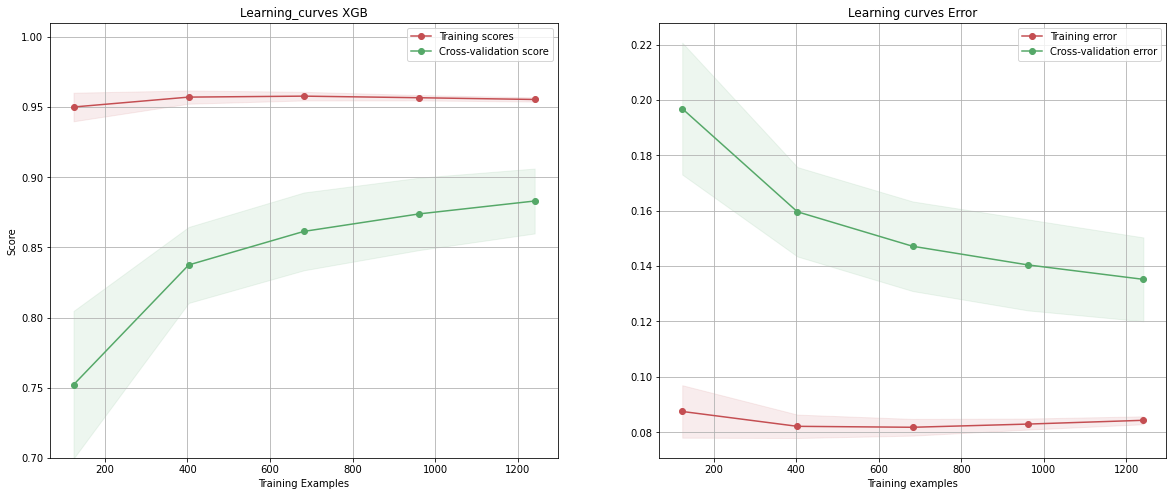

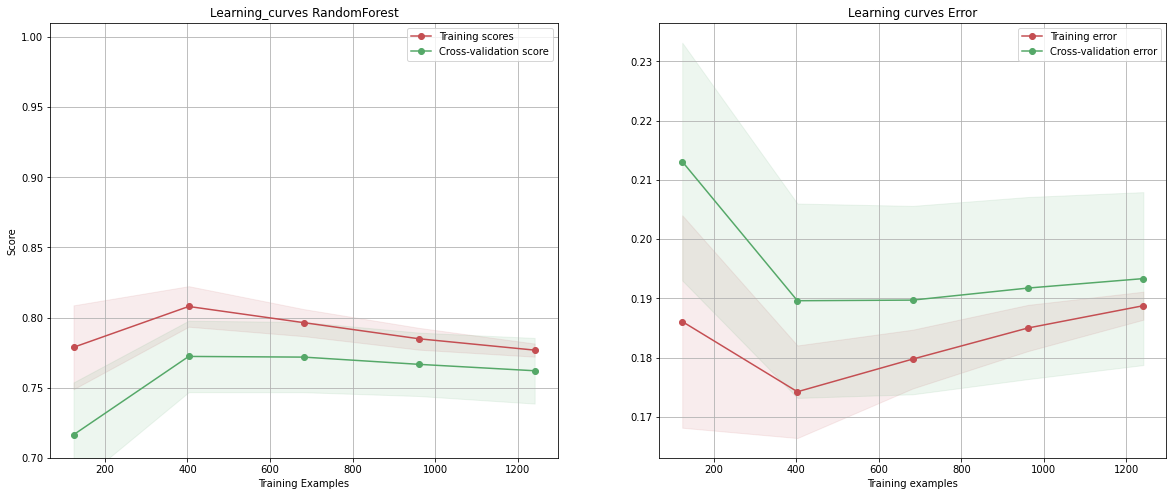

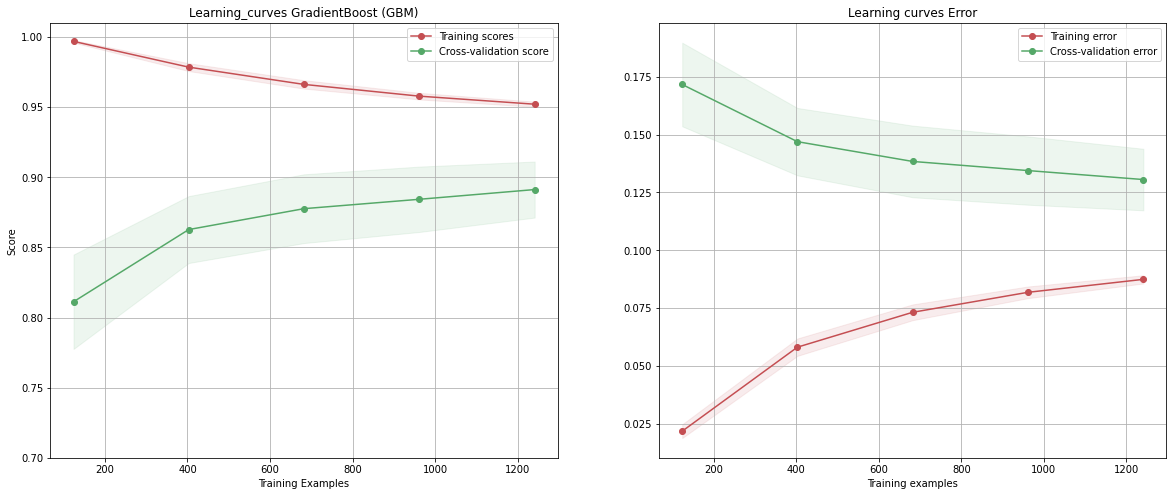

In [168]:
## Different models 

## Cross-validation , with 85% for training set and 15% for test set
cv = ShuffleSplit(n_splits=100,test_size = 0.15,random_state = 0)

## Plot learning curves for each model

## Learning curves xgboost
title_XGB = "Learning_curves XGB"
plot_learning_curves(XGB_best, title_XGB, X_norm, y_log, ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

## Learning curves RandomForest
title_RandForest = "Learning_curves RandomForest"
plot_learning_curves(RandForest_best, title_RandForest, X_norm, y_log, ylim=(0.7, 1.01),
                     cv=cv, n_jobs=4)

## Learning curves Gradient Boosting
title_GBM = "Learning_curves GradientBoost (GBM)"
plot_learning_curves(GBM_best, title_GBM, X_norm, y_log, ylim=(0.7, 1.01),
                     cv=cv, n_jobs=4)

## display curves
plt.show()

In [169]:
## Preparing the testing data
predictors = ['OverallQual', 'GrLivArea', 'BsmtFinSF1', 'ExterQual', 'LotArea', 'GarageCars','KitchenQual', 
              'MasVnrArea', 'BsmtQual', 'OverallCond','YearBuilt', 'MSSubClass', 'BsmtExposure', 'Fireplaces', 
              'MasVnrType', 'RoofMatl', 'Functional', 'PoolQC', 'PoolArea', 'WoodDeckSF','SaleCondition', 'Exterior1st',
              'BsmtFullBath', 'TotRmsAbvGrd', 'BedroomAbvGr', 'KitchenAbvGr', '1stFlrSF', '2ndFlrSF', 'LotFrontage', 'Condition2',
              'GarageType', 'Street', 'ScreenPorch', 'GarageFinish', 'FireplaceQu', 'Neighborhood']

## Normalize testing set
X_test_norm = scaler.fit_transform(test_data[predictors])

In [178]:
## Prediction of SalePrices for the test data ##
## Using the best model ## 

y_test_pred  = XGB_best.predict(X_test_norm)

In [179]:
print("Predicted House Prices : " , np.expm1(y_test_pred))

Predicted House Prices :  [124982.99 156467.11 184762.69 ... 142587.58 122852.17 228345.88]


In [177]:
## Kaggle submission ##
 
output = pd.DataFrame({'Id': [i for i in range(1461,2920)],
                       'SalePrice': np.expm1(y_test_pred).reshape(np.expm1(y_test_pred).shape[0]) })
output.to_csv('submission.csv', index=False)